In [3]:
%matplotlib inline
#%matplotlib notebook
from matplotlib.widgets import SpanSelector

import array as arr
import binascii
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import statistics as s
import sys

from datetime import datetime, time, timedelta
from itertools import count # izip for maximum efficiency
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path, PureWindowsPath
from scipy import fftpack, signal
from scipy.signal import find_peaks,tukey
from statistics import mean
from tkinter import filedialog
from tkinter import *

Sample_frequency = "global"
Sample_rate = "global"
Sample_frequency = 2.56
Sample_rate = 1. / Sample_frequency

In [4]:
def get_file():
# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "G:\Transfer\skardon_outer",\
    title = "Select BVA file",filetypes = (("BVA files","*.bva"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [5]:
def Displacement(valu):
# Decode real time data to Displacements_List in metres
# See DWTP 2.1.1 p20. Formula 16
    return (0.457*math.sinh(valu/457.))

In [6]:
def twos_complement(value, bitWidth):
    if value >= 2**bitWidth:
        # This catches value that is out of range
        raise ValueError("Value: {} out of range of {}-bit value.".format(value, bitWidth))
    else:
        return value - int((value << 1) & 2**bitWidth)

In [7]:
def Get_Displacements(Displacements_List):    
    n = 0
    for m in range(2304):
 
#######################################
# Read displacement data and convert to actual values
# Refer to DWTP pp.19-21 AND Datawell Waverider RX-C4 Receiver Manual p.38
#######################################
##        line_number = Cycle_counter[m]
        displacement_record = Displacements_List[n+m]
#        status_byte = displacement_record[0:1]
#        Status.append(status_byte)
        record_0 = displacement_record[1:3]
        record_1 = displacement_record[3:5]
        record_2 = displacement_record[5:7]
        record_3 = displacement_record[7:9]
        record_4 = displacement_record[9:11]
        record_5 = displacement_record[11:13]
        record_6 = displacement_record[13:15]
        record_7 = displacement_record[15:17]
        record_8 = displacement_record[17:19]
        
# Build the 12 bit HEX value from the 8 bit records 0 to 8        
        h0 = record_0+record_1[0]; n0 = record_1[1]+record_2; w0 = record_3+record_4[0]
        h1 = record_4[1]+ record_5; n1 = record_6+record_7[0]; w1= record_7[1]+record_8
        
### Need to include check for NAN here !!!

# Convert the 12 bit HEX value into a signed integer, and then into actual displacement value
        h0_sign = Displacement(twos_complement(int(h0,16),12))
        n0_sign = Displacement(twos_complement(int(n0,16),12))
        w0_sign = Displacement(twos_complement(int(w0,16),12))
        h1_sign = Displacement(twos_complement(int(h1,16),12))
        n1_sign = Displacement(twos_complement(int(n1,16),12))
        w1_sign = Displacement(twos_complement(int(w1,16),12))
        
# Build lists holding each of the displacement values
        wls.append(h0_sign); wls.append(h1_sign) 
        north.append(n0_sign); north.append(n1_sign)
        west.append(w0_sign); west.append(w1_sign)

    return(wls,north,west)

In [29]:
def Plot_wls(wls,Times,Below):
        
    plt.figure(figsize=(25,40))
    plt.subplot(4, 1, 1)
    x = 0; y = 1152
    plt.xlim(left = 0,right = 450)
    plt.ylim(bottom = 0-round(Hmax+0.5)/2,top = round(Hmax+0.5)/2)
    plt.plot(Times[x:y+5],wls[x:y+5],marker='x',markersize=4)
    plt.plot([Times[x],Times[y+5]],[0.1,0.1],"-g")
    plt.plot([Times[x],Times[y+5]],[-0.1,-0.1],"-g")
    bb = (np.abs(Below-y)).argmin()
    plt.plot(Times[Below[0:bb+1]],wls[Below[0:bb+1]],"-r",marker='o',markersize=6)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)

    plt.subplot(4, 1, 2)
    x = 1152; y = 2304
    plt.xlim(left = 450,right = 900)
    plt.ylim(bottom = 0-round(Hmax+0.5)/2,top = round(Hmax+0.5)/2)
    plt.plot(Times[x-5:y+5],wls[x-5:y+5],marker='x',markersize=4)
    plt.plot([Times[x-5],Times[y+5]],[0.1,0.1],"-g")
    plt.plot([Times[x-5],Times[y+5]],[-0.1,-0.1],"-g")
    aa = (np.abs(Below-x)).argmin()
    bb = (np.abs(Below-y)).argmin()
    plt.plot(Times[Below[aa-1:bb+1]],wls[Below[aa-1:bb+1]],"-r",marker='o',markersize=6)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)

    plt.subplot(4, 1, 3)
    x = 2304; y = 3456
    plt.xlim(left = 900,right = 1350)
    plt.ylim(bottom = 0-round(Hmax+0.5)/2,top = round(Hmax+0.5)/2)
    plt.plot(Times[x-5:y+5],wls[x-5:y+5],marker='x',markersize=4)
    plt.plot([Times[x-5],Times[y+5]],[0.1,0.1],"-g")
    plt.plot([Times[x-5],Times[y+5]],[-0.1,-0.1],"-g")
    aa = (np.abs(Below-x)).argmin()
    bb = (np.abs(Below-y)).argmin()
    plt.plot(Times[Below[aa-1:bb+1]],wls[Below[aa-1:bb+1]],"-r",marker='o',markersize=6)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)

    plt.subplot(4, 1, 4)
    x = 3456; y = 4607
    plt.xlim(left = 1350,right = 1800)
    plt.ylim(bottom = 0-round(Hmax+0.5)/2,top = round(Hmax+0.5)/2)
    plt.plot(Times[x-5:y],wls[x-5:y],marker='x',markersize=4)
    plt.plot([Times[x-5],Times[y]],[0.1,0.1],"-g")
    plt.plot([Times[x-5],Times[y]],[-0.1,-0.1],"-g")
    aa = (np.abs(Below-x)).argmin()
    bb = (np.abs(Below-y)).argmin()
    plt.plot(Times[Below[aa-1:bb]],wls[Below[aa-1:bb]],"-r",marker='o',markersize=6)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)

    plt.show() 
    
    return()   # Plot_wls

    4.2806    2.9163    2.3696    1.7114    7.3236       286


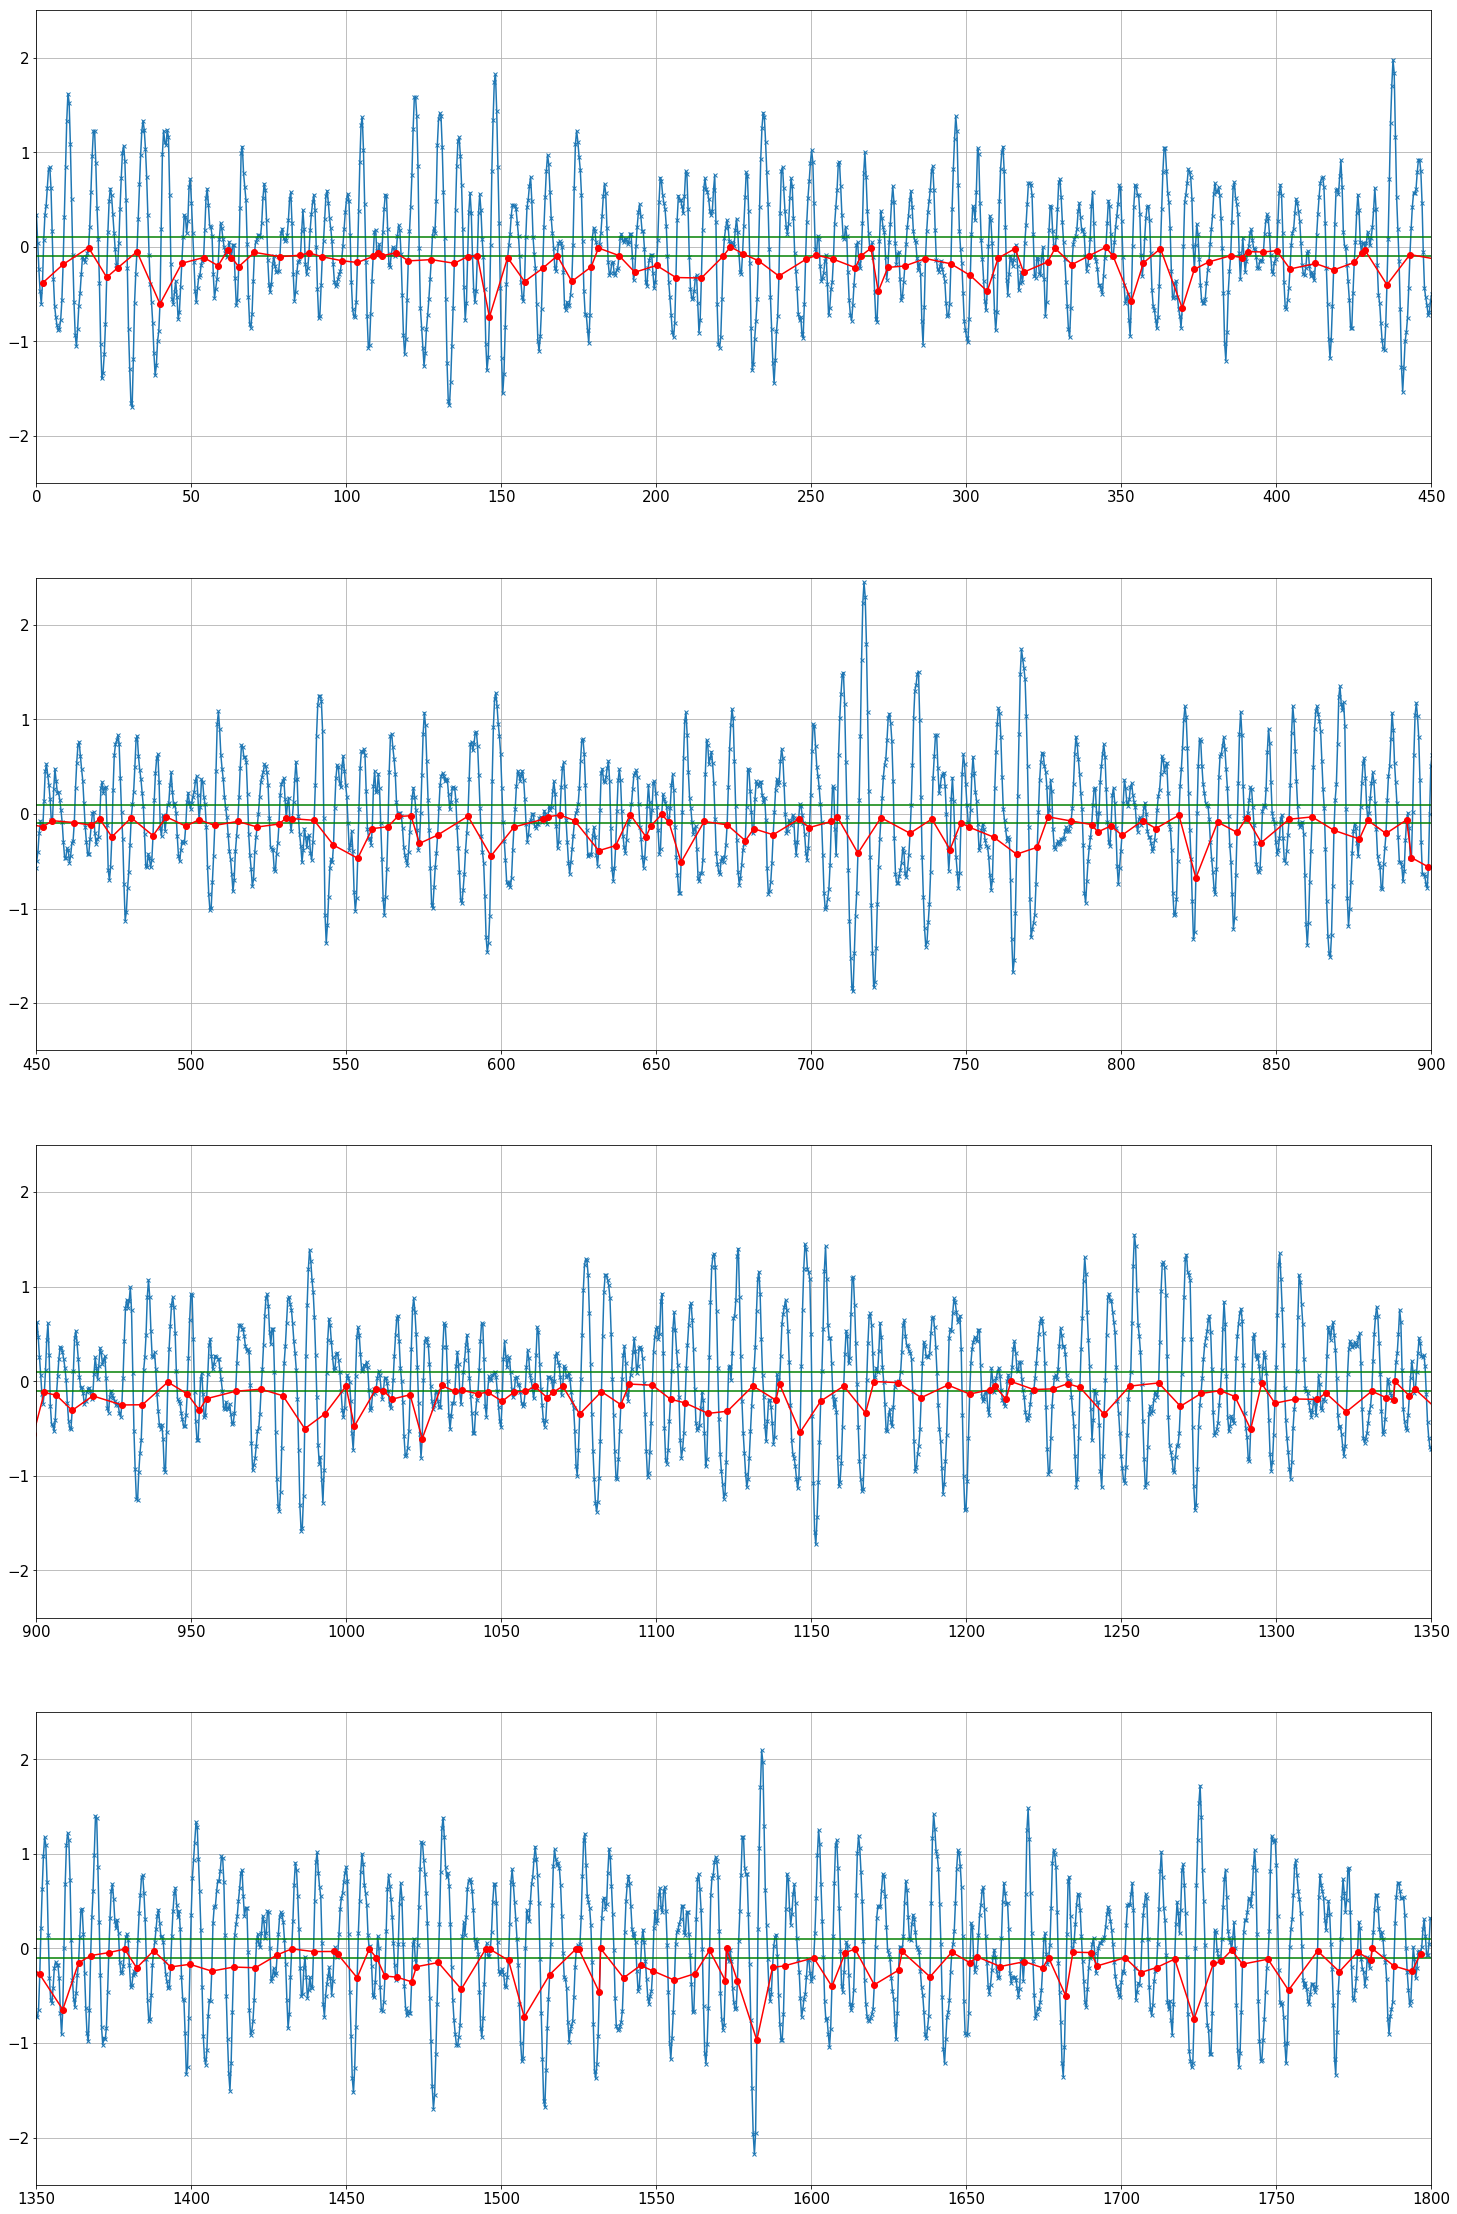

()

In [30]:
# Create a DT based on the structure type of the Datawell .BVA file format
BB1 = np.dtype([
    ('R0', 'B'),('R1', 'B'),('R2', 'B'),('R3', 'B'),('R4', 'B'),('R5', 'B'),('R6', 'B'),('R7', 'B'),('R8', 'B'),
    ('P9', 'B'),('P10', 'B'),('P11', 'B')
    ])

# Get name of input PRIM file
Input_BVA_File = get_file()

date_str = Input_BVA_File.split('/')[-1].split('.')[0]
Start_time = datetime.strptime(date_str, "%Y%m%d")
Next_time = Start_time; F20_time = Start_time; F23_time = datetime.now()

# Open file
f = open(Input_BVA_File)

# Read data from the Binary file into a DF based on the structure in the DT
data = pd.DataFrame(np.fromfile(f, BB1))

# Convert the values into their Hex equivalents
data = data.applymap(lambda x:(repr(hex(x)).upper())[-3:-1])

# Need to make adjustment of Hex values less-than or equal-to 'F'
data = data.replace({'X'}, {'0'}, regex=True)
data1 = data
# Build the HVA format minus the cyclically-counting line number
Displacements_DF = '-'+data['R0']+data['R1']+data['R2']+data['R3']+data['R4']+data['R5']\
                    +data['R6']+data['R7']+data['R8']

# Transform DF's into Lists
Displacements_List = []; Packet_List = []
Displacements_List = Displacements_DF.tolist()
wls = []; north = []; west = []
wls, north, west = Get_Displacements(Displacements_List)
wls = np.array(wls)

Times = np.linspace(0,1800,num=4608) # <<<<<<<<<<<<<<<<<<<<<<<<<<< Remove this when using real data

zero_crossings = np.where(np.diff(np.sign(wls)))[0] # Identify points to be used in identifying individual waves
Starting_point = zero_crossings[np.nonzero(zero_crossings)][0] # Locate initial point to determine first up-crossing

Below = zero_crossings[np.where(wls[zero_crossings]<=0)]

i = 0; j = i+1
waves = []; Periods = []; Wave_num = 0; Max_wave = 0
while i in range(len(Below)-2):
    wave = wls[Below[i]+1:Below[j]+1]   
    if max(wave) > 0.1 and min(wave) < -0.1:  # Either no crest above threshold or trough below it
    # get the individual wave heights - the sums of the crest heights and trough heights
        Height = max(wave)-min(wave)
        if (Height>Max_wave): 
            Max_wave = Height
            Max_wave_location = i
        waves.append(Height)
        
# get the individual wave periods - the sums of increments of wse's plus the zero-crossing bits
        H1 = wls[Below[i]+1]-wls[Below[i]]
        h1 = abs(wls[Below[i]])
        delta_h1= float(h1*0.39)/float(H1)
        
        H2 = wls[Below[j]+2]-wls[Below[j]+1]
        h2 = abs(wls[Below[j]+1])
        delta_h2= float(h2*0.39)/float(H2)
        
        period = Times[Below[j]+1]-Times[Below[i]+1]-delta_h1+delta_h2
        Periods.append(period)
#       print('{:10d}{:10.4f}{:10.4f}{:10.4f}{:10.4f}'.format(i+1,wls[Below[i]],wls[Below[j]],Height,period))
        Wave_num +=1
        i=j; j+=1
    else:
        j+=1
#        print('{:5d}{:3s}{:10.4f}{:3s}{:10.4f}{:3s}{:10.4f}{:3s}{:10.4f}'.format(i+1,'H1=',H1,'h1=',h1,'H2=',H2,'h2=',h2))
#       print('{:10d}{:11s}{:10.4f}{:10.4f}{:10.4f}{:10.4f}'.format(i,'   No wave',wls[Below[i]],wls[Below[j]],max(wave),min(wave)))
#       print('--------------------------------------------------')
        
# Sort the waves and determine Time-Domain heights
waves = np.asarray(waves)
sorted_waves = np.sort(waves)[::-1]
Hmax = max(sorted_waves)
Hsig = mean(sorted_waves[0:math.trunc(len(sorted_waves)/3)])
H10 = mean(sorted_waves[0:math.trunc(len(sorted_waves)*.1)])
Hrms = np.sqrt(np.mean(sorted_waves**2))

# Get Time-Domain periods
Periods = np.asarray(Periods)
THsig = Periods[np.abs(waves - Hsig).argmin()]

print('{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10.4f}{:10d}'.format(Hmax,H10,Hsig,Hrms,THsig,Wave_num))

Plot_wls(wls,Times,Below)



In [ ]:
plt.subplot(4, 1, 2)
    x = 1152; y = 2304
    plt.ylim(bottom = 0-round(Hmax+0.5)/2,top = round(Hmax+0.5)/2)
    plt.plot(Times[x-5:y+5],wls[x-5:y+5],marker='x',markersize=4)
    plt.plot([Times[x-5],Times[y+5]],[0.1,0.1],"-g")
    plt.plot([Times[x-5],Times[y+5]],[-0.1,-0.1],"-g")
    aa = (np.abs(Below-x)).argmin()
    bb = (np.abs(Below-y)).argmin()
    plt.plot(Times[Below[aa-1:bb+1]],wls[Below[aa-1:bb+1]],"-r",marker='o',markersize=6)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)

    plt.subplot(4, 1, 3)
    x = 2304; y = 3456
    plt.ylim(bottom = 0-round(Hmax+0.5)/2,top = round(Hmax+0.5)/2)
    plt.plot(Times[x-5:y+5],wls[x-5:y+5],marker='x',markersize=4)
    plt.plot([Times[x-5],Times[y+5]],[0.1,0.1],"-g")
    plt.plot([Times[x-5],Times[y+5]],[-0.1,-0.1],"-g")
    aa = (np.abs(Below-x)).argmin()
    bb = (np.abs(Below-y)).argmin()
    plt.plot(Times[Below[aa-1:bb+1]],wls[Below[aa-1:bb+1]],"-r",marker='o',markersize=6)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)

    plt.subplot(4, 1, 4)
    x = 3456; y = 4607
    plt.ylim(bottom = 0-round(Hmax+0.5)/2,top = round(Hmax+0.5)/2)
    plt.plot(Times[x-5:y],wls[x-5:y],marker='x',markersize=4)
    plt.plot([Times[x-5],Times[y]],[0.1,0.1],"-g")
    plt.plot([Times[x-5],Times[y]],[-0.1,-0.1],"-g")
    aa = (np.abs(Below-x)).argmin()
    bb = (np.abs(Below-y)).argmin()
    plt.plot(Times[Below[aa-1:bb]],wls[Below[aa-1:bb]],"-r",marker='o',markersize=6)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
